Load Data: https://www.kaggle.com/rmisra/news-category-dataset/code?datasetId=32526&searchQuery=df+%3D+pd.read_json%28file_path%2C+lines+%3D+True%29

Main Code: https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65

RUS/ROS: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/


In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
import pandas as pd
def load_data(file_path):
    df = pd.read_json(file_path, lines = True)
    df['category'] = pd.Categorical(df['category'])
    df = df[df["short_description"] != ""]
    df['headlineDesc'] = df['headline']+ ' ' + df['short_description']
    return df[["headlineDesc", "category"]]

df = load_data('News_Category_Dataset_v2.json')
df.head()

,headlineDesc,category
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT


In [4]:
#different than original baseline (keras instead of spacy)
from keras.preprocessing.text import Tokenizer
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.headlineDesc)
X = tokenizer.texts_to_sequences(df.headlineDesc)
df['words'] = X
vocab_size = len(tokenizer.word_index) + 1
# delete some empty and short data
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]
df.head()

,headlineDesc,category,words,word_length
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME,"[72, 100, 269, 1339, 2992, 6, 719, 133, 99, 25...",27
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,"[42, 1642, 3030, 29315, 5, 27163, 5247, 8, 1, ...",20
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT,"[5897, 5371, 8449, 8, 1, 77, 54, 21, 420, 8450...",25
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,"[2786, 14389, 3767, 62936, 2342, 13028, 5, 578...",26
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,"[40141, 35327, 1541, 95, 45, 8344, 3148, 2, 94...",26


In [5]:
from keras.preprocessing import sequence
import numpy as np
maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))
categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

word_index = tokenizer.word_index

EMBEDDING_DIM = 100

embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 114348 unique tokens.
Total 400000 word vectors.


In [6]:
from keras import layers
from keras.initializers import Constant
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X, Y = ros.fit_resample(X, Y)

In [ ]:
# split to training set, validation set, test
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2

In [ ]:
from keras.models import Sequential, Model
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = layers.Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11434900    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
11367/11367 [==============================] - 221s 19ms/step - loss: 2.4316 - accuracy: 0.3020 - val_loss: 2.0023 - val_accuracy: 0.4128
Epoch 2/30
11367/11367 [==============================] - 207s 18ms/step - loss: 1.9713 - accuracy: 0.4242 - val_loss: 1.7529 - val_accuracy: 0.4822
Epoch 3/30
11367/11367 [==============================] - 206s 18ms/step - loss: 1.7984 - accuracy: 0.4711 - val_loss: 1.6193 - val_accuracy: 0.5164
Epoch 4/30
11367/11367 [==============================] - 206s 18ms/step - loss: 1.6929 - accuracy: 0.4991 - val_loss: 1.5250 - val_accuracy: 0.5459
Epoch 5/30
11367/11367 [==============================] - 205s 18ms/step - loss: 1.6205 - accuracy: 0.5183 - val_loss: 1.4658 - val_accuracy: 0.5559
Epoch 6/30
11367/11367 [==============================] - 205s 18ms/step - loss: 1.5660 - accuracy: 0.5327 - val_loss: 1.4249 - val_accuracy: 0.5684
Epoch 7/30
11367/11367 [==============================] - 206s 18ms/step - loss: 1.5210 - accuracy: 0.5440

In [ ]:
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
3789/3789 [==============================] - 30s 8ms/step - loss: 1.0255 - accuracy: 0.6871
test loss, test acc: [1.0254660844802856, 0.6871162056922913]


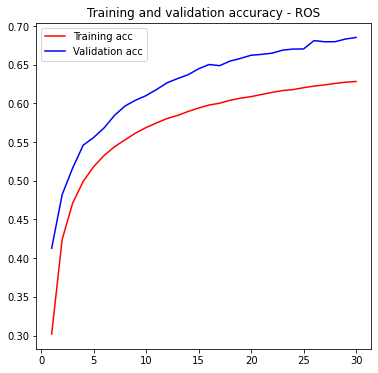

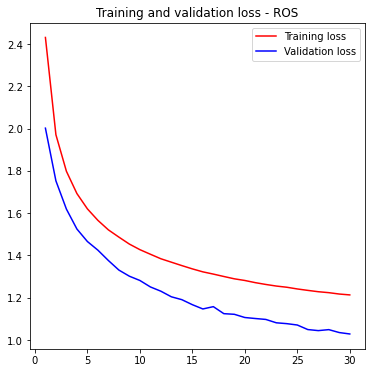

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy - ROS')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()
plt.savefig("train_val_ROS_acc.png")
plt.figure()
plt.title('Training and validation loss - ROS')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.savefig("train_val_ROS_loss.png")
plt.show()

**SMOTE approach**

In [7]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=1)
X, Y = oversample.fit_resample(X,Y)

In [8]:
# split to training set, validation set, test
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2

In [9]:
from keras.models import Sequential, Model
from keras.backend import clear_session
clear_session()

from tensorflow.keras import models
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
inp = layers.Input(shape=(maxlen,), dtype='int32')
embedding_layer = layers.Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

## embedding
x = embedding_layer(inp)
## apply attention
x = attention_layer(x, neurons=50)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.5, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=50, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(41, activation='softmax')(x)
## compile
model = models.Model(inp, y_out)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 100)      11434900    ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 100, 50)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 100, 50)      2550        ['permute[0][0]']                
                                                                                              

In [10]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
11367/11367 [==============================] - 179s 15ms/step - loss: 3.3004 - accuracy: 0.1143 - val_loss: 3.1896 - val_accuracy: 0.1400
Epoch 2/30
11367/11367 [==============================] - 170s 15ms/step - loss: 3.1715 - accuracy: 0.1454 - val_loss: 3.1203 - val_accuracy: 0.1549
Epoch 3/30
11367/11367 [==============================] - 170s 15ms/step - loss: 3.1205 - accuracy: 0.1557 - val_loss: 3.0742 - val_accuracy: 0.1650
Epoch 4/30
11367/11367 [==============================] - 170s 15ms/step - loss: 3.0837 - accuracy: 0.1641 - val_loss: 3.0423 - val_accuracy: 0.1733
Epoch 5/30
11367/11367 [==============================] - 169s 15ms/step - loss: 3.0568 - accuracy: 0.1706 - val_loss: 3.0163 - val_accuracy: 0.1792
Epoch 6/30
11367/11367 [==============================] - 170s 15ms/step - loss: 3.0355 - accuracy: 0.1756 - val_loss: 3.0032 - val_accuracy: 0.1817
Epoch 7/30
11367/11367 [==============================] - 169s 15ms/step - loss: 3.0177 - accuracy: 0.1798

In [11]:
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
3789/3789 [==============================] - 24s 6ms/step - loss: 2.8974 - accuracy: 0.2095
test loss, test acc: [2.897360324859619, 0.20946210622787476]


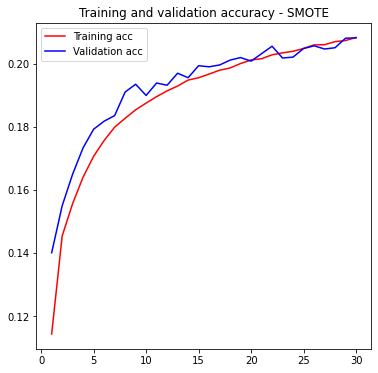

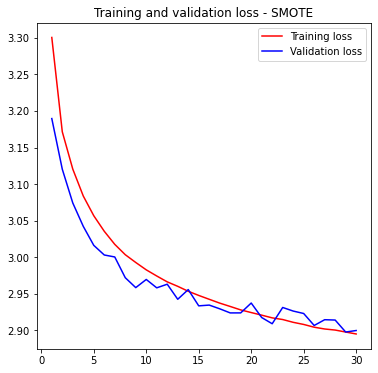

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy - SMOTE')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()
plt.savefig("train_val_smote_acc.png")
plt.figure()
plt.title('Training and validation loss - SMOTE')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()
plt.savefig("train_val_smote_loss.png")
plt.show()